This notebook will train the first LightGBM models. We are going to throw every feature from the dataset into the model and compare their importances to an added random noise column. Any feature with a feature importance less than random noise should be removed, unless it is clear the lack of importance is due to poor feature engineering (the feature may be a categorical column that can be engineered differently).

Instead of a random 5 fold cv, the data will be split by time. Although it may seem silly to train of future data to predict on historical, it will give some estimate of model/feature ability to generalize over time. It will atleast show more potential to generalize than a random shuffle split

In [8]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import KFold
import lightgbm as lgb
from scipy.cluster import hierarchy as hc
import scipy
from scipy import stats
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 50)

In [9]:
data_path = 'data/'

In [10]:
train_df = pd.read_pickle(data_path+'train_lgbm.pkl')
test_df = pd.read_pickle(data_path+'test_lgbm.pkl')

In [11]:
to_drop = ['issue_d','desc','loan_status', 'total_pymnt','total_rec_int',
           'total_rec_late_fee','total_rec_prncp', 'recoveries', 
           'collection_recovery_fee', 'last_pymnt_d', 
           'loan_length', 'returns', 'CPIAUCSL','prev_mo_cpi']
x_cols = [x for x in list(train_df.columns) if x not in to_drop]

In [12]:
# add noise
train_df['noise'] = np.random.uniform(-10,10, size = len(train_df))

In [13]:
x_cols.append('noise')

In [14]:
# define a few helper functions we will use repeatedly
def train_model(params, train_df, kf,x_cols=x_cols,save_model=False):

    # save fold scores
    scores = []

    # for fold predictions
    train_df['pred_returns'] = 0

    # feature importance dfs
    importance = pd.DataFrame(x_cols,columns=['Feature'])
    importance['gain'] = 0
    importance['split'] = 0


    # 5 fold split
    
    i = 0
    for train_ind, val_ind in kf.split(train_df):

        # split data
        x_train = train_df.iloc[train_ind][x_cols]
        y_train = train_df.iloc[train_ind]['returns']

        x_val = train_df.iloc[val_ind][x_cols]
        y_val = train_df.iloc[val_ind]['returns']

        train_data = lgb.Dataset(x_train,label=y_train)
        val_data = lgb.Dataset(x_val, label=y_val)

        # train model
        lgb_model = lgb.train(params,
                              train_data,
                              num_boost_round=10000,
                              valid_sets = [train_data, val_data],
                              verbose_eval=100,
                              early_stopping_rounds = 100)

        # Out-of-fold train prediction
        train_preds = lgb_model.predict(x_val)
        train_df.loc[val_ind,'pred_returns'] = train_preds

        # save scores
        score = r2_score(y_val,lgb_model.predict(x_val))
        scores.append(score)

        print(score)

        # feature importances
        gain_sum = lgb_model.feature_importance(importance_type='gain').sum()
        
        importance['gain'] += lgb_model.feature_importance(importance_type='gain')/gain_sum
        importance[f'gain_{i}'] = lgb_model.feature_importance(importance_type='gain')/gain_sum
        
        importance['split'] += lgb_model.feature_importance(importance_type='split')/5
        importance[f'split_{i}'] = lgb_model.feature_importance(importance_type='split')
        # save model
        if save_model==True:
            lgb_model.save_model(f'models/model_{i}.txt')
        i += 1
        
    return train_df, importance, np.array(scores)

def conf_interval(train_df=train_df,return_thresh=0.07,N=100,conf=0.95):
    high_returns = train_df.loc[train_df['pred_returns']>=return_thresh]
    high_returns = high_returns['returns']
    mu = high_returns.mean()
    sigma = high_returns.std()
    return mu, stats.norm.interval(conf, loc=mu, scale=sigma/np.sqrt(N))

def plot_importance(importance,imp_type,max_features=None):
    temp = importance.sort_values(by=imp_type,ascending=True)
    if max_features:
        temp = temp[-max_features:]
    plt.title(f'Feature Importance by {imp_type}')
    plt.barh(temp['Feature'],temp[imp_type]);

In [15]:
# sort data by time
train_df = train_df.sort_values('issue_d')
train_df.reset_index(inplace=True,drop=True)

In [16]:
kf = KFold(n_splits=5, shuffle=False, random_state=11)

# default params
params = {'num_leaves': 32,
          'learning_rate':0.1,
          'metric': 'rmse'}
train_df, importance, scores = train_model(params, train_df, kf)

Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.153413	valid_1's rmse: 0.152499
Early stopping, best iteration is:
[66]	training's rmse: 0.15442	valid_1's rmse: 0.15213
0.012699186998850087
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.154789	valid_1's rmse: 0.145317
[200]	training's rmse: 0.152412	valid_1's rmse: 0.145227
Early stopping, best iteration is:
[145]	training's rmse: 0.153625	valid_1's rmse: 0.145208
0.012634482135910008
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.151768	valid_1's rmse: 0.157773
[200]	training's rmse: 0.149434	valid_1's rmse: 0.157795
Early stopping, best iteration is:
[120]	training's rmse: 0.151227	valid_1's rmse: 0.157753
0.017686816331198618
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.15129	valid_1's rmse: 0.159542
[200]	training's rmse: 0.148911	valid_1's rmse: 0.15953
Early stopping,

In [17]:
scores.mean()

0.014851962911252459

In [21]:
# gives 95% confidence interval on a portfolio selected of 100 loans 
# based on return threshold to decide which loans to invest in
conf_interval(train_df=train_df,return_thresh=0.07,N=100,conf=0.95)

(0.0819983798978038, (0.053695802470768744, 0.11030095732483886))

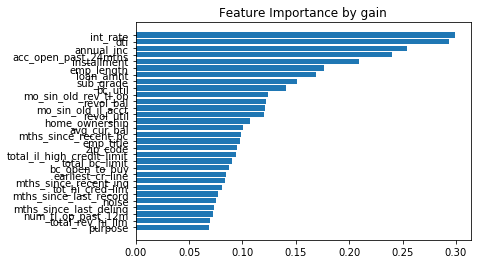

In [22]:
plot_importance(importance,'gain',30)

In [23]:
# remove columns with feature importance less than random noise
noise_gain = importance.loc[importance['Feature']=='noise','gain'].values[0]
to_drop = list(importance.loc[importance['gain']<=noise_gain,'Feature'])
x_cols = [x for x in x_cols if x not in to_drop]
len(x_cols)

25

In [24]:
# Store x_cols
import pickle
with open('x_cols.pickle', 'wb') as f:
    pickle.dump(x_cols, f)

In [25]:
# retrain model with new features, also with some hyperparameter tuning
params = {'num_leaves': 16,
          'learning_rate':0.05,
          'metric': 'rmse'}
train_df, importance, scores = train_model(params, train_df, kf,x_cols=x_cols,save_model=True)

Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.155946	valid_1's rmse: 0.152289
[200]	training's rmse: 0.155219	valid_1's rmse: 0.152162
[300]	training's rmse: 0.154627	valid_1's rmse: 0.152704
Early stopping, best iteration is:
[215]	training's rmse: 0.155126	valid_1's rmse: 0.152148
0.012474968194091551
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.157384	valid_1's rmse: 0.145692
[200]	training's rmse: 0.156629	valid_1's rmse: 0.145451
[300]	training's rmse: 0.156033	valid_1's rmse: 0.145367
[400]	training's rmse: 0.155484	valid_1's rmse: 0.145319
[500]	training's rmse: 0.154999	valid_1's rmse: 0.14529
[600]	training's rmse: 0.154572	valid_1's rmse: 0.145254
[700]	training's rmse: 0.15415	valid_1's rmse: 0.145254
Early stopping, best iteration is:
[653]	training's rmse: 0.154344	valid_1's rmse: 0.145246
0.01212966449663122
Training until validation scores don't improve for 100 rounds.
[100]	training's r

In [26]:
scores.mean()

0.01515746398263904

In [27]:
conf_interval(train_df=train_df,return_thresh=0.07,N=100,conf=0.95)

(0.08171942632229362, (0.054132029061209216, 0.10930682358337802))

Next plot loan performance on models predicted returns vs actuals

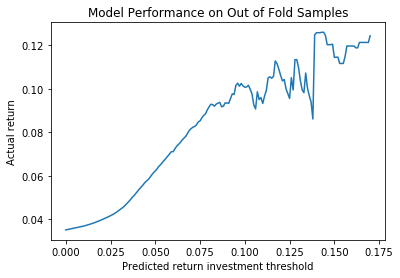

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

returns = []
# for each investment threshold
for t in np.arange(0,0.5, 0.001):
    
    # calculate average returns
    av_return = train_df.loc[train_df['pred_returns']>=t, 'returns'].mean()
    
    # also store how many potential loans there are to invest
    total_loans = len(train_df.loc[train_df['pred_returns']>=t, 'total_pymnt'])
    returns.append((av_return, t, total_loans))

plt.figure()
plt.plot([x[1] for x in returns], [x[0] for x in returns])
plt.title('Model Performance on Out of Fold Samples')
plt.xlabel('Predicted return investment threshold')
plt.ylabel('Actual return');

In [29]:
size = len(train_df); size

529873

In [30]:
# this shows actual return followed by predicted returnes, and num loans available at that threshold
# limit values to investment thresholds that are available to at least 1% loans
returns = list(filter(lambda x: x[2] > int(size*0.01), returns))
returns.sort(key=lambda x: x[0], reverse=True)
returns[:10]

[(0.08346460745989258, 0.073, 5618),
 (0.0827346126260264, 0.07200000000000001, 6267),
 (0.08236178594361976, 0.07100000000000001, 7031),
 (0.08171942632229362, 0.07, 7951),
 (0.08091560094451997, 0.069, 8922),
 (0.07953747263350189, 0.068, 9990),
 (0.07817065478360631, 0.067, 11235),
 (0.07732269229671049, 0.066, 12694),
 (0.0764979283710934, 0.065, 14236),
 (0.07538304979045123, 0.064, 15998)]

In [31]:
# train set average returns
train_df.returns.mean()

0.03131349458319939

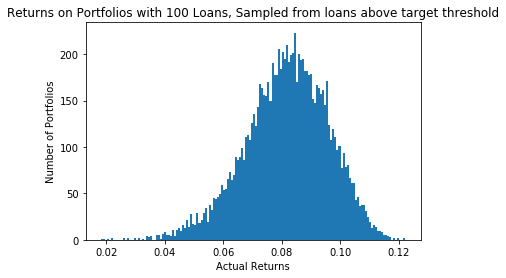

In [33]:
# plot distribution of sampled portfolios
high_returns = train_df.loc[train_df['pred_returns']>=0.07]
high_returns = high_returns['returns']

from scipy import stats
high_returns.mean()

returns = []
for i in range(10000):
    returns.append(np.random.choice(high_returns,size=100,replace=True).mean())
plt.hist(returns,bins=150)
plt.title('Returns on Portfolios with 100 Loans, Sampled from loans above target threshold')
plt.xlabel('Actual Returns')
plt.ylabel('Number of Portfolios');

In [37]:
# av returns, confidence interval, percantage of loans available to invest in
conf_interval(train_df,return_thresh=0.07), len(train_df.loc[train_df['pred_returns']>=0.07])/len(train_df)

((0.08171942632229362, (0.054132029061209216, 0.10930682358337802)),
 0.015005482445793614)

In [38]:
conf_interval(train_df,return_thresh=0.075), len(train_df.loc[train_df['pred_returns']>=0.075])/len(train_df)

((0.08526510355401297, (0.056509643012810785, 0.11402056409521516)),
 0.008605835737997596)

In [39]:
conf_interval(train_df,return_thresh=0.08), len(train_df.loc[train_df['pred_returns']>=0.08])/len(train_df)

((0.09168250843632615, (0.06304926284963079, 0.12031575402302151)),
 0.005135192772607776)

In [27]:
import os
test_df['pred_returns'] = 0
for m in os.listdir('models/'):
    if m[-4:] == '.txt':
        print(m)
        model = lgb.Booster(model_file=f'models/{m}')
        preds = model.predict(test_df[x_cols])
        test_df['pred_returns'] += preds/5

model_2.txt
model_3.txt
model_1.txt
model_0.txt
model_4.txt


In [28]:
conf_interval(train_df=test_df,return_thresh=0.07,N=100,conf=0.95)

(0.07152281877293333, (0.032995064872479996, 0.11005057267338667))

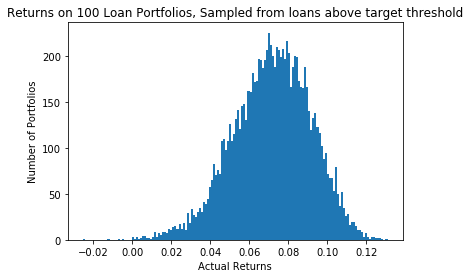

In [29]:
high_returns = test_df.loc[test_df['pred_returns']>=0.07]
high_returns = high_returns['returns']

returns = []
for i in range(10000):
    returns.append(np.random.choice(high_returns,size=100,replace=True).mean())
plt.hist(returns,bins=150)
plt.title('Returns on 100 Loan Portfolios, Sampled from loans above target threshold')
plt.xlabel('Actual Returns')
plt.ylabel('Number of Portfolios');

In [36]:
len(high_returns)

1720

In [30]:
len(high_returns)/len(test_df)

0.005784195694137112

In [31]:
conf_interval(train_df=test_df,return_thresh=0.07,N=100,conf=0.95)

(0.07152281877293333, (0.032995064872479996, 0.11005057267338667))

In [32]:
conf_interval(train_df=test_df,return_thresh=0.07,N=100,conf=0.99)

(0.07152281877293333, (0.020888767188563494, 0.12215687035730316))

In [33]:
conf_interval(train_df=test_df,return_thresh=0.075,N=100,conf=0.95)

(0.08052039516946284, (0.04175675401275023, 0.11928403632617546))

In [34]:
conf_interval(train_df=test_df,return_thresh=0.075,N=100,conf=0.99)

(0.08052039516946284, (0.029576335180959507, 0.13146445515796618))